In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Some new snapshot "features"

OpenPathSampling allows the fields of a snapshot (known as "snapshot features") to vary depending on the engine. This notebook demonstrates several new snapshot features that I added to OPS.

An important concept here is the use of "duck typing" in Python. The name comes from a quote by poet James Whitcomb Riley: "When I see a bird that walks like a duck and swims like a duck and quacks like a duck, I call that bird a duck." The behavior of the object defines the nomenclature, not the other way around.

Similarly, OpenPathSampling `Snapshot`s have a certain set of "features." As long as these features share common names and interpretations, they can be reused in various parts of the code. However, code should be ready to fail gracefully if these features do not exist.

Snapshot features in OpenPathSampling do not need to be data stored per-snapshot: they can instead be computed on the fly, or stored as a single copy relevant for all snapshots made by the same `DynamicsEngine` instance. None of the new features described here are stored inside the snapshot itself.

This notebook covers several features, which have been implemented in both the toy engine and the OpenMM engine. Other engines should consider implementing them as well:

* `masses`
* `n_degrees_of_freedom`
* `instantaneous_temperature`

One of the important points is that OpenMM uses units, which can give different outputs than the unitless toy engine. These details will be discussed below.

The next two cells create a couple of simple trajectories which we'll use to illustrate these features.

In [2]:
# create toy engine trajectory
from openpathsampling.engines import toy as toy_engine
topology = toy_engine.Topology(
    n_atoms=1,
    n_spatial=2,
    masses=[1.0],
    pes=toy_engine.LinearSlope(m=[0.0, 0.0], c=0.0)  # flat plane
)
options = {
    'integ': toy_engine.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
    'n_frames_max' : 5000,
    'n_steps_per_frame' : 1
}

engine_1 = toy_engine.Engine(
    options=options,
    topology=topology
)

snapshot = toy_engine.Snapshot(
    coordinates=np.array([[0.0, 0.0]]),
    velocities=np.array([[0.0, 0.0]]),
    engine=engine_1
)

# we'll start from zero KE, and watch the thermostat kick us up to the correct value
toy_trajectory = engine_1.generate(snapshot, running=[lambda traj, foo: len(traj) < 2000])

In [3]:
# create OpenMM engine trajectory
from openpathsampling.engines import openmm as openmm_engine
import openmmtools as omt
import simtk.unit as u

test_system = omt.testsystems.AlanineDipeptideVacuum()
template = openmm_engine.snapshot_from_testsystem(test_system)
engine_2 = openmm_engine.Engine(
    topology=template.topology,
    system=test_system.system,
    integrator=omt.integrators.VVVRIntegrator()
)
template = template.copy_with_replacement(engine=engine_2)  # start with correct enngine
openmm_trajectory = engine_2.generate(template, running=[lambda traj, foo: len(traj) < 500])

## `masses`

For the toy engine, the `masses` aspect is relatively straightforward. It returns the (unitless) mass from the topoloy object.

In [4]:
print(toy_trajectory[0].masses[0])

1.0


In OpenMM, things are bit more subtle, due to the use of units. Internally, OpenMM returns energies in units of energy/mole, instead of true energy. This is accomplished by treating masses (specifically, treating the unit for daltons, `Da`) not as a true mass, but as units of mass/mole.

However, if you want to use the masses for real physics (e.g., selecting velocities from a Boltzmann distribution), you need a true unit of mass (e.g., grams). According to OpenMM's definition of `Da`, we have `g = mol Da`.

In OpenPathSampling, the `masses` attribute returns true masses. For OpenMM, we also add a `masses_per_mole` attribute which returns the same as the OpenMM `masses`.

In [5]:
print(openmm_trajectory[0].masses[0])
print(openmm_trajectory[0].masses[0].in_units_of(u.gram))
print(openmm_trajectory[0].masses_per_mole[0])

1.67382309343e-24 mol Da
1.67382309343e-24 g
1.008 Da


## `n_degrees_of_freedom`

For the two system, the number of degrees of freedom is trivial: it is just the number of spatial degrees of freedom time the number of independent "atoms" (the toy models are usually one "atom" moving in a 2D external potential.)

In [6]:
print(toy_trajectory[10].n_degrees_of_freedom)

2


For OpenMM, we must account for constraints on the motion, such as motion removers (e.g., no overall linear momentum, which removes `n_spatial` degrees of freedom) and bond constraints. The total number of degrees of freedom without constraints in $3N$.

In [7]:
# this gives us 3 * n_atoms -- number of DOFs without constraints
print("Possible dofs (3*N):", 3 * len(openmm_trajectory[10].xyz))
print("Actual dofs:", openmm_trajectory[10].n_degrees_of_freedom)

Possible dofs (3*N): 66
Actual dofs: 51


In the OpenMM example, 66-51=15 possible degrees of freedom have been removed. In this case, that's 3 from linear momentum, 3 from angular momentum, and the remaining 9 come from constraining distances in bonds to hydrogens.

## `instantaneous_temperature`

The instantaneous temperature can be calculated in very similar ways for both. Again, the toy version is very straightforward:

In [8]:
toy_instantaneous = [s.instantaneous_temperature for s in toy_trajectory]

toy_cumulative = [toy_instantaneous[0]]
for T_inst in toy_instantaneous[1:]:
    toy_cumulative.append(toy_cumulative[-1] + T_inst)
toy_running_average = [toy_cumulative[i] / float(i+1) 
                       for i in range(len(toy_cumulative))]

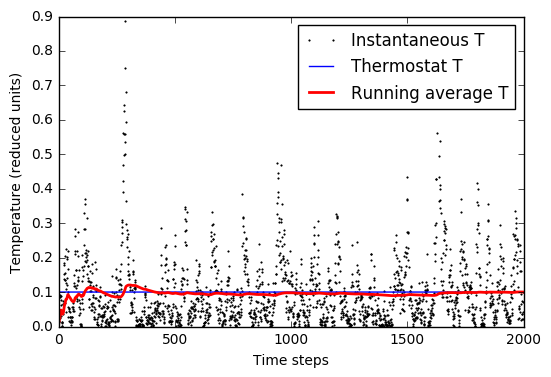

In [9]:
plt.plot(toy_instantaneous, 'k.', markersize=2, label='Instantaneous T')
plt.plot([0.1]*len(toy_instantaneous), ls='-', c='b', label='Thermostat T')
plt.plot(toy_running_average, lw=2, c='r', label='Running average T')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Temperature (reduced units)")

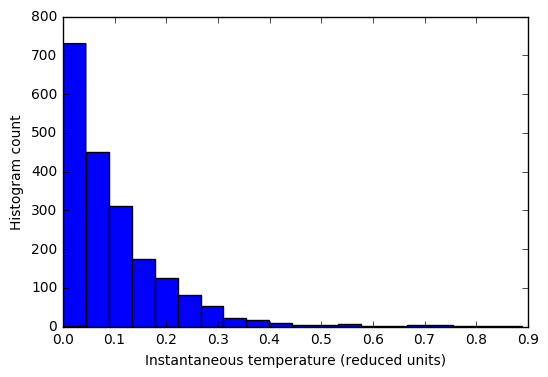

In [10]:
(counts, bins, patches) = plt.hist(toy_instantaneous, bins=20)
plt.xlabel("Instantaneous temperature (reduced units)")
plt.ylabel("Histogram count")

The main difference for the OpenMM version is that temperature comes in units of Kelvin. Units need to be stripped in order to be plotted by matplotlib.

In [11]:
openmm_instantaneous = [s.instantaneous_temperature / u.kelvin
                        for s in openmm_trajectory]

openmm_cumulative = [openmm_instantaneous[0]]
for T_inst in openmm_instantaneous[1:]:
    openmm_cumulative.append(openmm_cumulative[-1] + T_inst)
openmm_running_average = [openmm_cumulative[i] / float(i+1) 
                          for i in range(len(openmm_cumulative))]

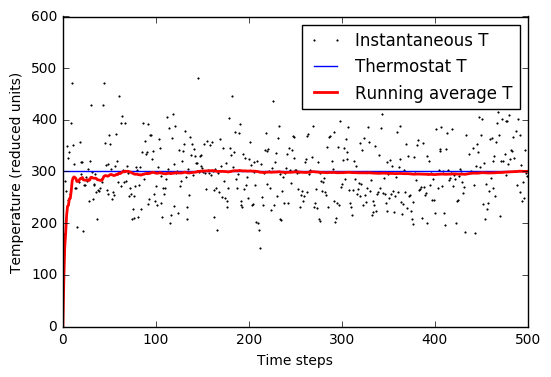

In [12]:
plt.plot(openmm_instantaneous, 'k.', markersize=2, label='Instantaneous T')
plt.plot([300]*len(openmm_instantaneous), ls='-', c='b', label='Thermostat T')
plt.plot(openmm_running_average, lw=2, c='r', label='Running average T')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Temperature (reduced units)")

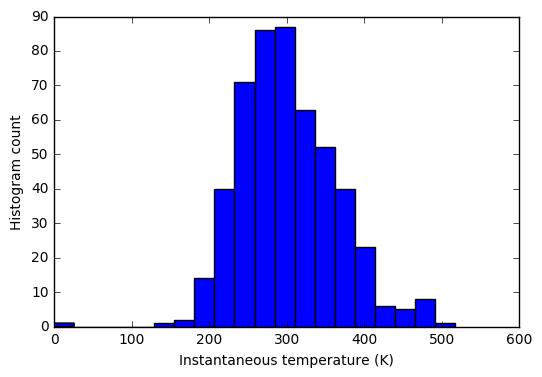

In [13]:
(counts, bins, patches) = plt.hist(openmm_instantaneous, bins=20)
plt.xlabel("Instantaneous temperature (K)")
plt.ylabel("Histogram count")